In [1]:
#!git clone https://github.com/sobrad956/CMSC472FinalProject.git

Cloning into 'CMSC472FinalProject'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 23 (delta 10), reused 17 (delta 8), pack-reused 0
Unpacking objects: 100% (23/23), 6.18 KiB | 791.00 KiB/s, done.


In [2]:
#!cd CMSC472FinalProject/

In [3]:
import torch
import torchvision as tv
import torch.random
import os
import sys
from PIL import Image
from torchvision import transforms
from torchvision.datasets import Food101
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt 
import matplotlib

In [4]:
# assumes original color temp maxed out at (255,255,255)
# expect Tensor of [..., 3 (r,g,b), H, W]
class RandomSaltPepper(torch.nn.Module):
    def __init__(self, p=0.5, type='salt'):
        super().__init__()
        self.p = p
        self.salt = type in ['salt', 'both']
        self.pepper = type in ['pepper', 'both']
        self.color = []
        if self.salt:
            self.color.append(1)
        if self.pepper:
            self.color.append(0)
    
    def forward(self, imgs):
        if not len(self.color):
            return imgs
                    
        # probably slow AF and not pythonic
        for i, img in enumerate(imgs):
            for h, row in enumerate(img[0]):
                for w, _ in enumerate(row):
                    if torch.rand(1) < self.p:
                        imgs[i,:,h,w] = self.color[torch.randint(0, len(self.color), (1,)).item()]
        
        return imgs

class RandomGaussianNoise(torch.nn.Module):
    def __init__(self, mean=0, var=1):
        super().__init__()
        self.mean = mean
        self.var = var
        self.sigma = var ** 0.5
        
    def forward(self, imgs):
        noise = torch.normal(self.mean, self.sigma, imgs.shape)
        imgs += noise
        imgs = torch.clamp(imgs, 0, 1)
        return imgs


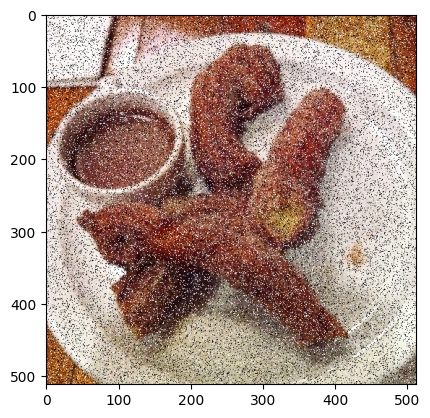

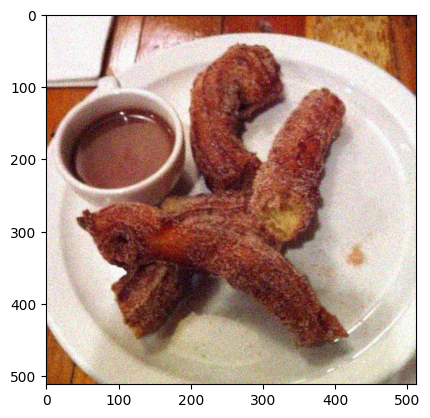

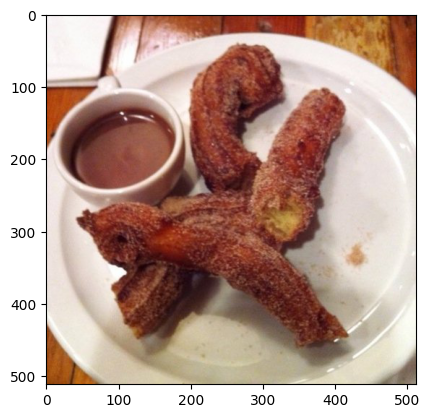

In [5]:
# simple testbench
if __name__ == '__main__':
    root = os.path.expanduser(os.path.join('~', 'data'))
    dataset = Food101(root=root, download=True, transform=ToTensor())
    aug = RandomSaltPepper(p=0.2, type='both')
    aug2 = RandomGaussianNoise(mean=0,var=1./255.)
    oim = torch.unsqueeze(dataset[0][0], 0)
    aim = aug(torch.clone(oim))
    aim2 = aug2(torch.clone(oim))
    plt.figure(0)
    plt.imshow(aim[0].permute(1,2,0))
    plt.figure(1)
    plt.imshow(aim2[0].permute(1,2,0))
    plt.figure(2)
    plt.imshow(oim[0].permute(1,2,0))
    plt.show()

In [6]:
len(dataset)

75750

In [7]:
import argparse
import torch

import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader

import os
import sys
import math

import shutil

import densenet 

In [12]:
def main():
  batchSz = 64
  nEpochs = 300
  save = True
  seed = 1
  opt = 'sgd'
  cuda = torch.cuda.is_available()
  save = 'work/densenet.base'
  torch.manual_seed(seed)
  if cuda:
    torch.cuda.manual_seed(seed)
  if os.path.exists(save):
        shutil.rmtree(save)
  os.makedirs(save, exist_ok=True)

  normMean = [0.49139968, 0.48215827, 0.44653124]
  normStd = [0.24703233, 0.24348505, 0.26158768]
  normTransform = transforms.Normalize(normMean, normStd)


  trainTransform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normTransform
    ])
  
  testTransform = transforms.Compose([
        transforms.Resize([32, 32]),
        transforms.ToTensor(),
        normTransform
    ])
  
  #Food101(root=root, download=True, transform=ToTensor())

  trainLoader = DataLoader(Food101(root=root, split="train", download=True, transform=trainTransform), batch_size = batchSz, shuffle=True)
  testLoader = DataLoader(dset.Food101(root=root, split="test", download=True, transform=testTransform), batch_size = batchSz, shuffle=False)
  net = densenet.DenseNet(growthRate=12, depth=100, reduction=0.5,  bottleneck=True, nClasses=101)

  print('  + Number of params: {}'.format(sum([p.data.nelement() for p in net.parameters()])))
  if cuda:
    net = net.cuda()

  

  trainF = open(os.path.join(save, 'train.csv'), 'w')
  testF = open(os.path.join(save, 'test.csv'), 'w')

  for epoch in range(1, nEpochs + 1):
    if epoch < 150: lr = 1e-1
    elif epoch == 150: lr = 1e-2
    elif epoch >= 225: lr = 1e-3
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    
    train(cuda, batchSz, nEpochs, save, epoch, net, trainLoader, optimizer, trainF)
    test(cuda, batchSz, nEpochs, save, epoch, net, testLoader, optimizer, testF)
    torch.save(net, os.path.join(save, 'latest.pth'))
    os.system('./plot.py {} &'.format(save))

  trainF.close()
  testF.close()

def train(cuda, batchSz, nEpochs, save, epoch, net, trainLoader, optimizer, trainF):
    net.train()
    nProcessed = 0
    nTrain = len(trainLoader.dataset)
    for batch_idx, (data, target) in enumerate(trainLoader):
        if(nProcessed > 400):
          break
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        print(data.shape)
        print(target.shape)
        print('-------------')
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        nProcessed += len(data)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect = pred.ne(target.data).cpu().sum()
        err = 100.*incorrect/len(data)
        partialEpoch = epoch + batch_idx / len(trainLoader) - 1
        print('Train Epoch: {:.2f} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tError: {:.6f}'.format(
            partialEpoch, nProcessed, nTrain, 100. * batch_idx / len(trainLoader),
            loss.item(), err))

        trainF.write('{},{},{}\n'.format(partialEpoch, loss.item(), err))
        trainF.flush()

def test(cuda, batchSz, nEpochs, save, epoch, net, testLoader, optimizer, testF):
    net.eval()
    test_loss = 0
    incorrect = 0
    for data, target in testLoader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = net(data)
        test_loss += F.nll_loss(output, target)
        pred = output.data.max(1)[1] # get the index of the max log-probability
        incorrect += pred.ne(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testLoader) # loss function already averages over batch size
    nTotal = len(testLoader.dataset)
    err = 100.*incorrect/nTotal
    print('\nTest set: Average loss: {:.4f}, Error: {}/{} ({:.0f}%)\n'.format(
        test_loss, incorrect, nTotal, err))

    testF.write('{},{},{}\n'.format(epoch, test_loss, err))
    testF.flush()


In [ ]:
main()

  + Number of params: 800375
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.00 [64/75750 (0%)]	Loss: 4.694174	Error: 100.000000
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.00 [128/75750 (0%)]	Loss: 4.682281	Error: 100.000000
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.00 [192/75750 (0%)]	Loss: 4.626432	Error: 98.437500
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.00 [256/75750 (0%)]	Loss: 4.667781	Error: 100.000000
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.00 [320/75750 (0%)]	Loss: 4.626533	Error: 98.437500
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.00 [384/75750 (0%)]	Loss: 4.715415	Error: 100.000000
torch.Size([64, 3, 32, 32])
torch.Size([64])
-------------
Train Epoch: 0.01 [448/75750 (1%)]	Loss: 4.639483	Error: 100.000000


<ipython-input-12-cb16d7ccf036>:100: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
